# Transfer Learning

### [Resource](https://www.learnpytorch.io/04_pytorch_custom_datasets/)

Previously we've built a few models by hand so far. But their performance has been poor.

So a question arises, **is there a well-performing model that already exists for our problem?**

Answer is yes, and the technique is called [transfer learning](https://developers.google.com/machine-learning/glossary#transfer-learning).

## What is Transfer Learning?
Transfer learning refers to a powerful technique in machine learning where knowledge gained from solving one problem is leveraged to tackle a different, but related problem. Essentially, it's like inheriting expertise from a learned source and applying it to a new challenge.

For instance, imagine we have a well-trained computer vision model that excels at recognizing various objects in images, thanks to its exposure to vast datasets like ImageNet. We can harness the learned patterns or "weights" from this model and adapt them to our own task, such as classifying food items in FoodVision Mini. This way, we don't have to start from scratch but can instead build upon the existing knowledge.

Similarly, in the realm of NLP, transfer learning allows us to benefit from language models that have already undergone extensive training on large text corpora. By incorporating the insights gleaned from these pre-trained models, we can develop more effective classifiers for distinguishing between different types of textual content.

In essence, transfer learning offers a shortcut to success by capitalizing on the expertise acquired by existing models and applying it creatively to solve new problems.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-example-overview.png">

## Why use Transfer Learning?
Here are compelling reasons to employ transfer learning:

- **Leverage Established Models:**</br> Transfer learning enables the utilization of pre-existing neural network architectures that have demonstrated effectiveness in addressing problems akin to our own. By leveraging these established models, we can benefit from their proven track record without needing to reinvent the wheel.

- **Utilize Learned Patterns:**</br>  Through transfer learning, we can harness the knowledge acquired by a model that has been trained on data similar to ours. This means that the model has already gleaned valuable patterns and insights, potentially leading to superior results with less reliance on extensive custom data.

<img src = "https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-for-foodvision-mini%20.png">

## Where to find pretrained models?

Often, code and pretrained models for the latest state-of-the-art research is released within a few days of publishing.

And there are several places you can find pretrained models to use for your own problems.

| Location                   | What's there?                                                                                                      | Link(s)                                                    |
|----------------------------|--------------------------------------------------------------------------------------------------------------------|------------------------------------------------------------|
| PyTorch domain libraries   | Each of the PyTorch domain libraries (torchvision, torchtext) come with pretrained models of some form. The models there work right within PyTorch.        | [`torchvision.models`](https://pytorch.org/docs/stable/torchvision/models.html)</br> [`torchtext.models`](https://pytorch.org/text/stable/models.html)</br> [`torchaudio.models`](https://pytorch.org/audio/stable/models.html)</br> [`torchrec.models`](https://pytorch.org/recommender/stable/models.html)       |
| HuggingFace Hub           | A series of pretrained models on many different domains (vision, text, audio and more) from organizations around the world. There's plenty of different datasets too.      | [Models](https://huggingface.co/models)</br> [Datasets](https://huggingface.co/datasets)                                     |
| timm (PyTorch Image Models) library | Almost all of the latest and greatest computer vision models in PyTorch code as well as plenty of other helpful computer vision features.                                  | [GitHub Repository](https://github.com/rwightman/pytorch-image-models)                                                |
| Paperswithcode            | A collection of the latest state-of-the-art machine learning papers with code implementations attached. You can also find benchmarks here of model performance on different tasks. | [Paperswithcode](https://paperswithcode.com/)                                                        |

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-transfer-learning-where-to-find-pretrained-models.png">



## What we're going to cover

We're going to take a pretrained model from `torchvision.models` and customise it to work on (and hopefully improve) our **FoodVision Mini** problem.

| Topic                           | Contents                                                                                                                                                 |
|---------------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------|
| 0. Getting setup                | We've written a fair bit of useful code over the past few sections, let's download it and make sure we can use it again.                                |
| 1. Get data                     | Let's get the mini FoodMNIST image classification dataset we've been using to try and improve our model's results.                                      |
| 2. Create Datasets and DataLoaders | We'll use the `data_setup.py` script we wrote in chapter [`05_PyTorch_Going_Modular`](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/05_PyTorch_Going_Modular) to setup our DataLoaders. |
| 3. Get and customise a pretrained model | Here we'll download a pretrained model from `torchvision.models` and customise it to our own problem.                                                 |
| 4. Train model                  | Let's see how the new pretrained model goes on our custom 8 food classes dataset. We'll use the training functions we created in the previous chapter. |
| 5. Evaluate the model by plotting loss curves | How did our first transfer learning model go? Did it overfit or underfit?                                                                               |
| 6. Make predictions on images from the test set | It's one thing to check out a model's evaluation metrics but it's another thing to view its predictions on test samples.                               |


## 0. Getting setup
Let's get started by importing/downloading the required modules for this section.

In [ ]:
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Setting device agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
try:
  from torchinfo import summary
except:
  !pip install torchinfo
  from torchinfo import summary

In [ ]:
# Download and Load the going_modular scripts
try:
    from going_modular import data_setup, dataset, engine
except ImportError:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/LuluW8071/Data-Science/
    !cp -r Data-Science/Pytorch/05_PyTorch_Going_Modular/going_modular .
    from going_modular import data_setup, dataset, engine

[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'Data-Science'...
remote: Enumerating objects: 1182, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (22/22), done.
remote: Total 1182 (delta 6), reused 1 (delta 0), pack-reused 1160
Receiving objects: 100% (1182/1182), 91.82 MiB | 32.94 MiB/s, done.
Resolving deltas: 100% (419/419), done.


Downloading...
From (original): https://drive.google.com/uc?id=1J0syU84FNmtxkf9AzDPdRSDmtUr1CSy8
From (redirected): https://drive.google.com/uc?id=1J0syU84FNmtxkf9AzDPdRSDmtUr1CSy8&confirm=t&uuid=d916a688-2b16-416e-99ab-97c7e75b012b
To: /content/Food_dataset.zip
100%|██████████| 367M/367M [00:05<00:00, 70.5MB/s]


Files extracted successfully to: ./dataset


## 1. Get data

To save us writing extra code, we're going to be leveraging some of the Python scripts (such as `data_setup.py`, `dataset.py` and `engine.py`) we created in the previous section, [`05_PyTorch_Going_Modular`](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/05_PyTorch_Going_Modular).

- `data_setup.py`: downloads the dataset
- `dataset.py`: contains the train and test dataloader functions
- `engine.py`: contains the train and test loop functions

 Then, setup paths to our training and test directories.

In [ ]:
# Setup directories for train and test
train_dir = "dataset/train"
test_dir = "dataset/test"

## 2. Create Datasets and DataLoaders

### 2.1 Creating a transform for `torchvision.models` (manual creation)

When using a pretrained model, it's important that your custom data going into the model is prepared in the same way as the original training data that went into the model.

All pre-trained models expect input images normalized in the same way, i.e. mini-batches of `3-channel` RGB images of shape `(3 x H x W)`, where `H` and `W` are expected to be at least 224.

|Transform number |	Transform required| 	Code to perform transform|
|----|-----|----|
|1 |	Mini-batches of size `[batch_size, 3, height, width]` where height and width are at least `224x224`^. |	`torchvision.transforms.Resize()` to resize images into `[3, 224, 224]`^ and `torch.utils.data.DataLoader()` to create batches of images.|
|2 	|Values between `0` & `1`. |	`torchvision.transforms.ToTensor()`|
|3 |	A mean of `[0.485, 0.456, 0.406]` (values across each colour channel). |	`torchvision.transforms.Normalize(mean=...)` to adjust the mean of our images.|
|4 |	A standard deviation of `[0.229, 0.224, 0.225]` (values across each colour channel). |	`torchvision.transforms.Normalize(std=...)` to adjust the standard deviation of our images.|


>NOTE:
 </br>Some pretrained models from `torchvision.models` in different sizes to `[3, 224, 224]`, for example, some might take them in `[3, 240, 240]`. For specific input image sizes, see the documentation.

>Where did the mean and standard deviation values come from? Why do we need to do this?

>These were calculated from the data. Specifically, the ImageNet dataset by taking the means and standard deviations across a subset of images.

>We also don't need to do this. Neural networks are usually quite capable of figuring out appropriate data distributions (they'll calculate where the mean and standard deviations need to be on their own) but setting them at the start can help our networks achieve better performance quicker.



In [ ]:
# Create a transforms pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((224, 224)),                    # 1. Reshape all images to 224x224 (though some models may require different sizes)
    transforms.ToTensor(),                            # 2. Turn image values to between 0 & 1
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # 3. A mean of [0.485, 0.456, 0.406] (across each colour channel)
                         std=[0.229, 0.224, 0.225])   # 4. A standard deviation of [0.229, 0.224, 0.225] (across each colour channel),
])

Now we've got a **manually created series of transforms** ready to prepare our images, let's create training and testing DataLoaders.

We can create these using the create_dataloaders function from the `dataset.py` script we created in [`05_PyTorch_Going_Modular`](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/05_PyTorch_Going_Modular).

In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = dataset.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=manual_transforms, # resize, convert images to between 0 & 1 and normalize them
                                                                            num_workers=1,
                                                                            batch_size=64)               # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7da74dbad540>,
 ['donuts',
  'dumplings',
  'ice_cream',
  'pizza',
  'ramen',
  'samosa',
  'steak',
  'sushi'])

### 2.2 Creating a transform for `torchvision.models` (auto creation)

Above we manually created a transform for a pretrained model. But we can also do an automatic transform creation.

When you setup a model from `torchvision.models` and select the pretrained model weights you'd like to use, for example, say we'd like to use:

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
```

In [ ]:
# Get a set of pretrained model weights
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

And now to access the transforms assosciated with our `weights`, we can use the `transforms()` method.

In [ ]:
# Get the transforms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


Notice how `auto_transforms` is very similar to `manual_transforms`, the only difference is that `auto_transforms` came with the model architecture we chose, where as we had to create `manual_transforms `by hand.

The benefit of automatically creating a transform through `weights.transforms()` is that you ensure you're using the same data transformation as the pretrained model used when it was trained.

However, the tradeoff of using automatically created transforms is a lack of customization.

We can use `auto_transforms` to create DataLoaders with `create_dataloaders()` just as before.


In [ ]:
# Create training and testing DataLoaders as well as get a list of class names
train_dataloader, test_dataloader, class_names = dataset.create_dataloaders(train_dir=train_dir,
                                                                            test_dir=test_dir,
                                                                            transform=auto_transforms, # perform same data transforms on our own data as the pretrained model
                                                                            num_workers=1,
                                                                            batch_size=32) # set mini-batch size to 32

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7da74707a500>,
 ['donuts',
  'dumplings',
  'ice_cream',
  'pizza',
  'ramen',
  'samosa',
  'steak',
  'sushi'])

## 3. Getting a pretrained model

Previosuly we builded PyTorch Neural Networks from scratch. And though its a good skill to have, datasets with complex features and large class labels are bound to perform bad even if we do complex data augmentation.

In order to make our model perform better we use predefined weights on the model. And, that's where __transfet learning__ comes in.

The whole idea of transfer learning is to __take an already well-performing model on a problem-space similar to yours and then customising it to your use case__.

Since we're working on a computer vision problem (image classification with FoodVision Mini), we can find pretrained classification models in `torchvision.models`.

Some of the popular computer vision architecture are:

| **Architecuture backbone** | **Code** |
| ----- | ----- |
| [ResNet](https://arxiv.org/abs/1512.03385)'s | `torchvision.models.resnet18()`, `torchvision.models.resnet50()`... |
| [VGG](https://arxiv.org/abs/1409.1556) (similar to what we used for TinyVGG) | `torchvision.models.vgg16()` |
| [EfficientNet](https://arxiv.org/abs/1905.11946)'s | `torchvision.models.efficientnet_b0()`, `torchvision.models.efficientnet_b1()`... |
| [VisionTransformer](https://arxiv.org/abs/2010.11929) (ViT's)| `torchvision.models.vit_b_16()`, `torchvision.models.vit_b_32()`... |
| [ConvNeXt](https://arxiv.org/abs/2201.03545) | `torchvision.models.convnext_tiny()`,  `torchvision.models.convnext_small()`... |
| More available in `torchvision.models` | `torchvision.models...` |

### 3.1 Which pretrained model to choose?

Selecting the right pretrained model depends on various factors, such as your specific problem and the device you're working with.

Typically, pretrained models with higher numbers in their names (e.g., `efficientnet_b0()` versus `efficientnet_b7()`) offer better performance but are also larger in size.

While better performance may seem desirable, it's essential to consider that some high-performing models may be too large to run efficiently on certain devices.

For instance, if you intend to deploy your model on a mobile device with limited compute resources, opting for a smaller model is advisable.

However, if you have ample compute power at your disposal, adhering to the philosophy of [*The Bitter Lesson*](http://www.incompleteideas.net/IncIdeas/BitterLesson.html) suggests selecting the largest, most computationally intensive model available.

Grasping this tradeoff between __performance__, __speed__, and __size__ is a skill that develops with experience and practice. Understanding how to balance these factors will be crucial in making informed decisions when selecting a pretrained model for your specific use case.

## 3.2 Setting up a pretrained model

The pretrained model we're going to be using is [`torchvision.models.efficientnet_b0()`](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b0.html).

The architecture is from the paper [_EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks_](https://arxiv.org/abs/1905.11946).

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-effnet-b0-feature-extractor.png" alt="efficienet_b0 from PyTorch torchvision feature extraction model" width=900/>

We can setup the `EfficientNet_B0` pretrained ImageNet weights using the same code as we used to create the transforms.

```python
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights for ImageNet
```

This means the model has already been trained on millions of images and has a good base representation of image data.



In [ ]:
# Setup the model with pretrained weights and send it to the target device
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT            # .DEFAULT = best available weights
model = torchvision.models.efficientnet_b0(weights=weights).to(device)

Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 41.0MB/s]


Our `efficientnet_b0` comes in three main parts:
1. `features` - A collection of convolutional layers and other various activation layers to learn a base representation of vision data (this base representation/collection of layers is often referred to as **features** or **feature extractor**, "the base layers of the model learn the different **features** of images").
2. `avgpool` - Takes the average of the output of the `features` layer(s) and turns it into a **feature vector**.
3. `classifier` - Turns the **feature vector** into a vector with the same dimensionality as the number of required output classes (since `efficientnet_b0` is pretrained on ImageNet and because ImageNet has 1000 classes, `out_features=1000` is the default).

### 3.3 Getting a summary of our model with `torchinfo.summary()`

To learn more about our model, let's use `torchinfo`'s [`summary()` method](https://github.com/TylerYep/torchinfo#documentation).

To do so, we'll pass in:
 * `model` - the model we'd like to get a summary of.
 * `input_size` - the shape of the data we'd like to pass to our model, for the case of `efficientnet_b0`, the input size is `(batch_size, 3, 224, 224)`, though [other variants of `efficientnet_bX` have different input sizes](https://github.com/pytorch/vision/blob/d2bfd639e46e1c5dc3c177f889dc7750c8d137c7/references/classification/train.py#L92-L93).
    * **Note:** Many modern models can handle input images of varying sizes thanks to [`torch.nn.AdaptiveAvgPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html), this layer adaptively adjusts the `output_size` of a given input as required. You can try this out by passing different size input images to `summary()` or your models.
 * `col_names` - the various information columns we'd like to see about our model.
 * `col_width` - how wide the columns should be for the summary.
 * `row_settings` - what features to show in a row.

In [ ]:
# Print a summary using torchinfo (uncomment for actual output)
summary(model=model,
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape"
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 8]              --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-unfrozen-layers.png" alt="output of torchinfo.summary() when passed our model with all layers as trainable" width=900/>

For reference, our model from previous sections, **Enhanced TinyVGG had 1,036,776 vs. 4,017,796 parameters for `efficientnet_b0`, an increase of ~387.52%**!

### 3.4 Freezing the base model and changing the output layer to suit our needs

The process of transfer learning usually goes: freeze some base layers of a pretrained model (typically the `features` section) and then adjust the output layers (also called head/classifier layers) to suit your needs.

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-v2-effnet-changing-the-classifier-head.png" alt="changing the efficientnet classifier head to a custom number of outputs" width=900/>

Let's freeze all of the layers/parameters in the `features` section of our `efficientnet_b0` model.

> **Note:** To *freeze* layers means to keep them how they are during training. For example, if your model has pretrained layers, to *freeze* them would be to say, "don't change any of the patterns in these layers during training, keep them how they are." In essence, we'd like to keep the pretrained weights/patterns our model has learned from ImageNet as a backbone and then only change the output layers.

We can freeze all of the layers/parameters in the `features` section by setting the attribute `requires_grad=False`.

For parameters with `requires_grad=False`, PyTorch doesn't track gradient updates and in turn, these parameters won't be changed by our optimizer during training.

In essence, a parameter with `requires_grad=False` is "untrainable" or "frozen" in place.

In [ ]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

Feature extractor layers frozen!

Let's now adjust the output layer or the `classifier` portion of our pretrained model to our needs.

Right now our pretrained model has `out_features=1000` because there are 1000 classes in ImageNet.

However, we don't have 1000 classes, we only have 8.

We can change the `classifier` portion of our model by creating a new series of layers.

The current `classifier` consists of:

```
(classifier): Sequential(
    (0): Dropout(p=0.2, inplace=True)
    (1): Linear(in_features=1280, out_features=1000, bias=True)
```

We'll keep the `Dropout` layer the same using [`torch.nn.Dropout(p=0.2, inplace=True)`](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

And we'll keep `in_features=1280` for our `Linear` output layer but we'll change the `out_features` value to the length of our `len(class_names) = 8`.

Our new `classifier` layer should be on the same device as our `model`.

In [ ]:
# Set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Get the length of class_names (one output unit for each class)
output_shape = len(class_names)

# Recreate the classifier layer and seed it to the target device
model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape, # same number of output units as our number of classes
                    bias=True)).to(device)

In [ ]:
# Update Model Summary
summary(model,
        input_size=(64, 3, 224, 224), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [64, 3, 224, 224]    [64, 8]              --                   Partial
├─Sequential (features)                                      [64, 3, 224, 224]    [64, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [64, 3, 224, 224]    [64, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [64, 3, 224, 224]    [64, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [64, 32, 112, 112]   [64, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [64, 32, 112, 112]   [64, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [64, 32, 112, 112]   [64, 

<img src="https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/06-torchinfo-summary-frozen-layers.png" alt="output of torchinfo.summary() after freezing multiple layers in our model and changing the classifier head" width=900/>

## 4. Train model

To begin training, let's create a loss function and an optimizer same as previous notebooks.

Because we're still working with multi-class classification, we'll use `nn.CrossEntropyLoss()` for the loss function.

And we'll stick with `torch.optim.Adam()` as our optimizer with `lr=0.001`.

To train our model, we can use `train()` function we defined in the [`05_PyTorch_Going_Modular`](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/05_PyTorch_Going_Modular).



In [ ]:
# Define loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Set the random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Setup training and save the results
results = engine.train(model=model,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=5,
                       device=device)

# End the timer and print out how long it took
end_time = timer()
print(f"[INFO] Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



Epoch: 1 | Train loss: 1.0930 - Train acc: 71.01% -- Test_loss: 0.5443 -- Test_acc: 87.64%

Epoch: 2 | Train loss: 0.6678 - Train acc: 80.59% -- Test_loss: 0.4244 -- Test_acc: 88.96%

Epoch: 3 | Train loss: 0.5751 - Train acc: 82.90% -- Test_loss: 0.3607 -- Test_acc: 90.36%

Epoch: 4 | Train loss: 0.5381 - Train acc: 82.96% -- Test_loss: 0.3365 -- Test_acc: 90.91%

Epoch: 5 | Train loss: 0.5040 - Train acc: 84.31% -- Test_loss: 0.3357 -- Test_acc: 90.32%
[INFO] Total training time: 315.882 seconds


With an `efficientnet_b0` backbone, our model achieves almost 90%+ accuracy on the test dataset which is around 15%+ higher accuracy than we trained on [`05_PyTorch_Going_Modular`](https://github.com/LuluW8071/Data-Science/tree/main/Pytorch/05_PyTorch_Going_Modular).

Not bad for a model we downloaded with a few lines of code.

## 5. Evaluate model by plotting loss curves

Our model looks like it's performing pretty well.

Let's plot it's loss curves to see what the training looks like over time.

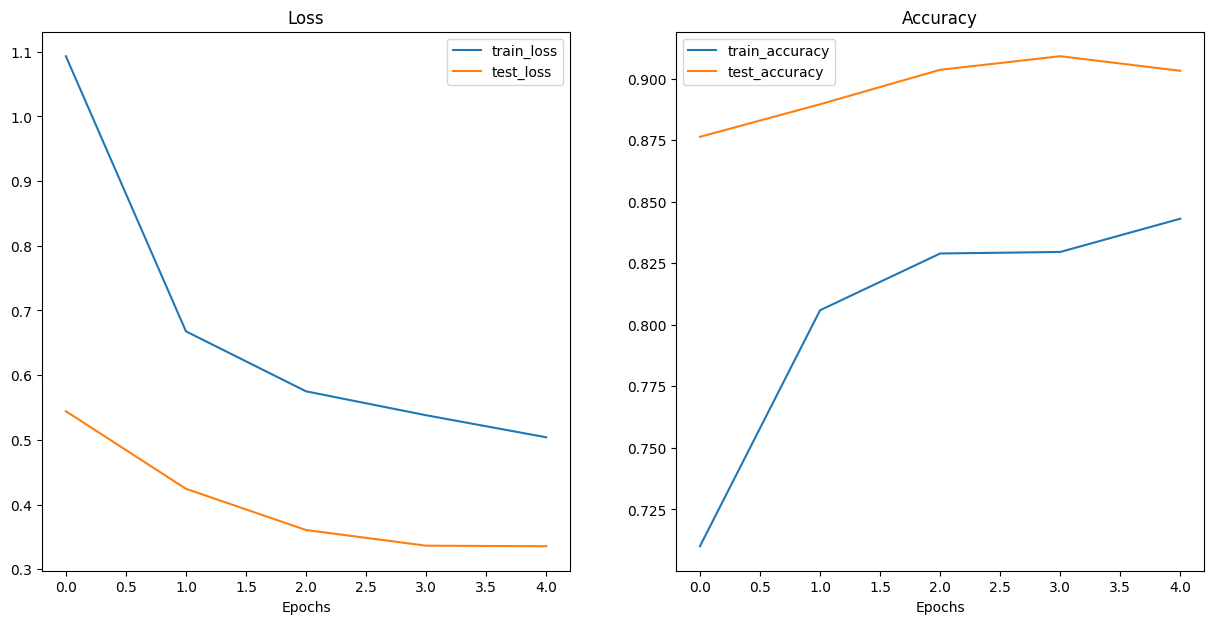

In [ ]:
import matplotlib.pyplot as plt

def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

# Plot the loss curves of our model
plot_loss_curves(results)

## 6. Make predictions on images from the test set

One thing we'll have to remember is that for our model to make predictions on an image, the image has to be in *same* format as the images our model was trained on.

This means we'll need to make sure our images have:
* **Same shape** - If our images are different shapes to what our model was trained on, we'll get shape errors.
* **Same datatype** - If our images are a different datatype (e.g. `torch.int8` vs. `torch.float32`) we'll get datatype errors.
* **Same device** - If our images are on a different device to our model, we'll get device errors.
* **Same transformations** - If our model is trained on images that have been transformed in certain way (e.g. normalized with a specific mean and standard deviation) and we try and make preidctions on images transformed in a different way, these predictions may be off.

To do all of this, we'll create a function `pred_and_plot_image()` to:

1. Take in a trained model, a list of class names, a filepath to a target image, an image size, a transform and a target device.
2. Open an image with [`PIL.Image.open()`](https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.open).
3. Create a transform for the image (this will default to the `manual_transforms` we created above or it could use a transform generated from `weights.transforms()`).
4. Make sure the model is on the target device.
5. Turn on model eval mode with `model.eval()` (this turns off layers like `nn.Dropout()`, so they aren't used for inference) and the inference mode context manager.
6. Transform the target image with the transform made in step 3 and add an extra batch dimension with `torch.unsqueeze(dim=0)` so our input image has shape `[batch_size, color_channels, height, width]`.
7. Make a prediction on the image by passing it to the model ensuring it's on the target device.
8. Convert the model's output logits to prediction probabilities with `torch.softmax()`.
9. Convert model's prediction probabilities to prediction labels with `torch.argmax()`.
10. Plot the image with `matplotlib` and set the title to the prediction label from step 9 and prediction probability from step 8.

In [ ]:
from typing import List, Tuple
from PIL import Image
from pathlib import Path

# 1. Take in a trained model, class names, image path, image size, a transform and target device
def pred_and_plot_image(model: torch.nn.Module,
                        image_path: str,
                        class_names: List[str],
                        image_size: Tuple[int, int] = (224, 224),
                        transform: torchvision.transforms = None,
                        device: torch.device=device):


    # 2. Open image
    img = Image.open(image_path)

    # 3. Create transformation for image (if one doesn't exist)
    if transform is not None:
        image_transform = transform
    else:
        image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225]),
        ])

    # Predict on image
    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
      # 6. Transform and add an extra dimension to image (model requires samples in [batch_size, color_channels, height, width])
      transformed_image = image_transform(img).unsqueeze(dim=0)

      # 7. Make a prediction on image with an extra dimension and send it to the target device
      target_image_pred = model(transformed_image.to(device))

    # 8. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 9. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 10. Plot image with predicted label and probability
    plt.figure()
    plt.imshow(img)
    plt.title(f"Pred: {class_names[target_image_pred_label]} | Prob: {target_image_pred_probs.max():.3f}")
    plt.axis(False);

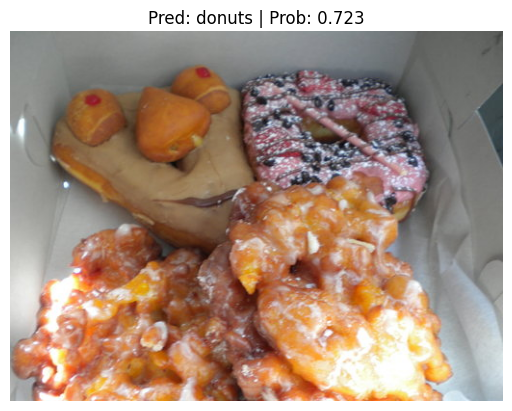

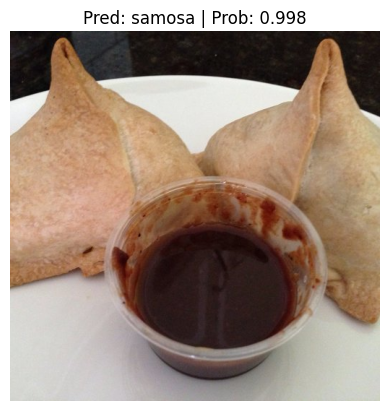

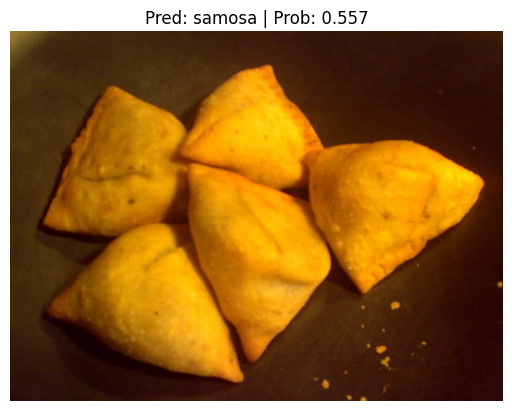

In [ ]:
# Get a random list of image paths from test set
import random

num_images_to_plot = 3
test_image_path_list = list(Path(test_dir).glob("*/*.jpg")) # get list all image paths from test data
test_image_path_sample = random.sample(population=test_image_path_list, # go through all of the test image paths
                                       k=num_images_to_plot) # randomly select 'k' image paths to pred and plot

# Make predictions on and plot the images
for image_path in test_image_path_sample:
    pred_and_plot_image(model=model,
                        image_path=image_path,
                        class_names=class_names,
                        # transform=weights.transforms(), # optionally pass in a specified transform from our pretrained model weights
                        image_size=(224, 224))

### 6.1 Making predictions on a custom image

Predicting on your own custom data, outisde of any training or test set.

To test our model on a custom image, let's import the any 8 classes of image food from google.

We'll then pass it to the `pred_and_plot_image()` function we created above and see what happens.

dataset/custom.jpeg already exists, skipping download.


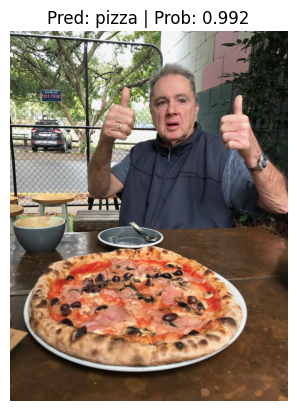

In [ ]:
import requests
from PIL import Image
from io import BytesIO

# Setup custom image path
data_path = Path("dataset/")
custom_image_path = data_path / "custom.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
    with open(custom_image_path, "wb") as f:
        request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
        print(f"Downloading {custom_image_path}...")
        f.write(request.content)
else:
    print(f"{custom_image_path} already exists, skipping download.")

# Try to open the image and handle errors
try:
    image = Image.open(custom_image_path)
    # Predict on custom image
    pred_and_plot_image(model=model,
                        image_path=custom_image_path,
                        class_names=class_names)
except Exception as e:
    print(f"Error opening image: {e}")


## Main takeaways
* **Transfer learning** often allows to you get good results with a relatively small amount of custom data.
* Knowing the power of transfer learning, it's a good idea to ask at the start of every problem, "does an existing well-performing model exist for my problem?"
* When using a pretrained model, it's important that your custom data be formatted/preprocessed in the same way that the original model was trained on, otherwise you may get degraded performance.
* The same goes for predicting on custom data, ensure your custom data is in the same format as the data your model was trained on.
* There are [several different places to find pretrained models](https://www.learnpytorch.io/06_pytorch_transfer_learning/#where-to-find-pretrained-models) from the PyTorch domain libraries, HuggingFace Hub and libraries such as `timm` (PyTorch Image Models).